In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale

In [2]:
df = pd.read_csv("wimbledon.csv")

Select a match to evaluate performance.

In [3]:
match_id = "2023-wimbledon-1301"
match_df = df[df["match_id"] == match_id]

In [4]:
eval_df = match_df.copy()

# Explode the columns to duplicate columns for each player
eval_df["player_id"] = None
for i in eval_df.index:
    eval_df.at[i, "player_id"] = (1, 2)
eval_df = (
    eval_df.explode("player_id")
    .reset_index(names="point_id")
    .set_index(["point_id", "player_id"])
)

# Assign info to the corresponding player
sep_cols = ["ace", "winner", "break_pt_won", "double_fault", "unf_err"]
eval_df_spec_criteria = [True, True, True, False, False]
for col in sep_cols:
    eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

# Victor by server or receiver
eval_df["victor_by_server"] = eval_df.apply(
    lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]), axis=1
)
eval_df["victor_by_receiver"] = eval_df.apply(
    lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]), axis=1
)
sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
eval_df_spec_criteria = [True, True] + eval_df_spec_criteria

eval_df_spec = eval_df[sep_cols]
eval_df_spec

victor_by_server  victor_by_receiver  ace  winner  \
point_id player_id                                                      
0        1                         0                   0    0       0   
         2                         0                   1    0       0   
1        1                         1                   0    0       0   
         2                         0                   0    0       0   
2        1                         0                   0    0       0   
...                              ...                 ...  ...     ...   
297      2                         0                   0    0       0   
298      1                         1                   0    0       0   
         2                         0                   0    0       0   
299      1                         1                   0    0       0   
         2                         0                   0    0       0   

                    break_pt_won  double_fault  unf_err  
point_id player_id                                       
0        1                     0             0        1  
         2                     0             0        0  
1        1                     0             0        0  
         2                     0             0        0  
2        1                     0             0        1  
...                          ...           ...      ...  
297      2                     0             0        0  
298      1                     0             0        0  
         2                     0             0        0  
299      1                     0             0        0  
         2                     0             0        0  

[600 rows x 7 columns]

Use the entropy weight method (EWM) to assign the weight for each feature.

In [5]:
scaled_values = minmax_scale(eval_df_spec.values, feature_range=(0.01, 0.99))
norm_values = scaled_values / np.sum(scaled_values, axis=0)
g = 1 + 1 / np.log(len(eval_df_spec)) * np.sum(
    norm_values * np.log(norm_values), axis=0
)
eval_df_spec_weights = g / np.sum(g)
{col: weight for col, weight in zip(eval_df_spec.columns, eval_df_spec_weights)}

{'victor_by_server': 0.08759087046360858,
 'victor_by_receiver': 0.1291685004290725,
 'ace': 0.1819738376659515,
 'winner': 0.13893251745765206,
 'break_pt_won': 0.1488164120563408,
 'double_fault': 0.16593199717316973,
 'unf_err': 0.1475858647542049}

Implement the technique for order of preference by similarity to ideal solution (TOPSIS) for evaluation.

In [6]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm**2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [7]:
topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_df_spec["performance"] = topsis.fit_predict()[1]
eval_df_spec

victor_by_server  victor_by_receiver  ace  winner  \
point_id player_id                                                      
0        1                         0                   0    0       0   
         2                         0                   1    0       0   
1        1                         1                   0    0       0   
         2                         0                   0    0       0   
2        1                         0                   0    0       0   
...                              ...                 ...  ...     ...   
297      2                         0                   0    0       0   
298      1                         1                   0    0       0   
         2                         0                   0    0       0   
299      1                         1                   0    0       0   
         2                         0                   0    0       0   

                    break_pt_won  double_fault  unf_err  performance  
point_id player_id                                                    
0        1                     0             0        1     0.423744  
         2                     0             0        0     0.453471  
1        1                     0             0        0     0.445615  
         2                     0             0        0     0.443012  
2        1                     0             0        1     0.423744  
...                          ...           ...      ...          ...  
297      2                     0             0        0     0.443012  
298      1                     0             0        0     0.445615  
         2                     0             0        0     0.443012  
299      1                     0             0        0     0.445615  
         2                     0             0        0     0.443012  

[600 rows x 8 columns]

In [8]:
p1_performance = eval_df_spec.loc[
    eval_df_spec.index.get_level_values("player_id") == 1, "performance"
]
p2_performance = eval_df_spec.loc[
    eval_df_spec.index.get_level_values("player_id") == 2, "performance"
]
p1_performance.index = p1_performance.index.droplevel("player_id")
p2_performance.index = p2_performance.index.droplevel("player_id")
df_performance = pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])
df_performance

,p1,p2
point_id,,
0,0.423744,0.453471
1,0.445615,0.443012
2,0.423744,0.453471
3,0.459815,0.443012
4,0.538465,0.443012
...,...,...
295,0.443012,0.453471
296,0.443012,0.467557
297,0.445615,0.443012


Plot the performance throughout the whole selected match.

In [9]:
double_faults = eval_df_spec[eval_df_spec["double_fault"] == 1].index
break_pt_wons = eval_df_spec[eval_df_spec["break_pt_won"] == 1].index

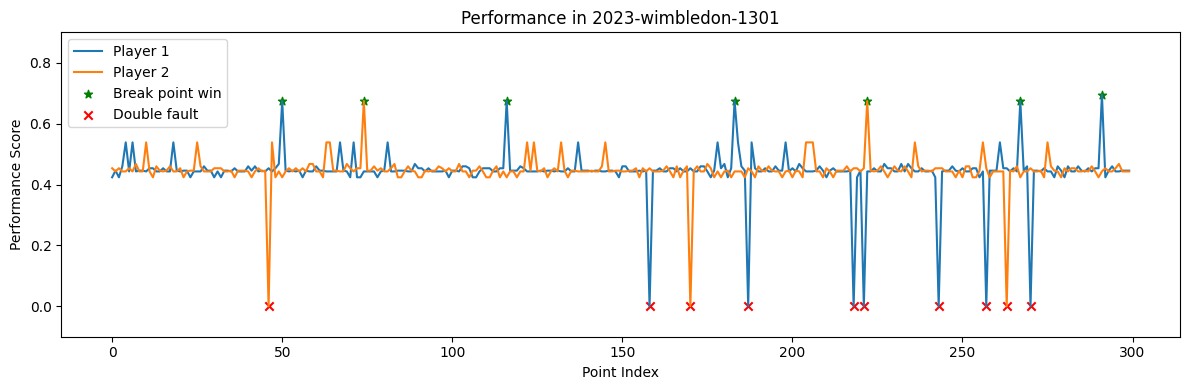

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(df_performance.index, df_performance["p1"], label="Player 1")
plt.plot(df_performance.index, df_performance["p2"], label="Player 2")
plt.scatter(
    break_pt_wons.get_level_values("point_id"),
    eval_df_spec.loc[break_pt_wons, "performance"],
    color="green",
    marker="*",
    label="Break point win",
)
plt.scatter(
    double_faults.get_level_values("point_id"),
    eval_df_spec.loc[double_faults, "performance"],
    color="red",
    marker="x",
    label="Double fault",
)
plt.xlabel("Point Index")
plt.ylabel("Performance Score")
plt.ylim(-0.1, 0.9)
plt.title(f"Performance in {match_id}")
plt.legend()
plt.tight_layout()
plt.show()

Plot the performance of a selected range of points in the selected match.

In [11]:
def plot_selected_range(ax, selected_range):
    selected_range = list(range(*selected_range))
    locator = eval_df_spec.index.get_level_values("point_id").isin(selected_range)
    df_performance_selected = df_performance.loc[selected_range]
    winners = eval_df_spec[(eval_df_spec["winner"] == 1) & locator].index
    unf_errs = eval_df_spec[(eval_df_spec["unf_err"] == 1) & locator].index

    ax.plot(selected_range, df_performance_selected["p1"], label="Player 1")
    ax.plot(selected_range, df_performance_selected["p2"], label="Player 2")
    ax.scatter(
        winners.get_level_values("point_id"),
        eval_df_spec.loc[winners, "performance"],
        color="green",
        marker="*",
        label="Untouchable winning shot",
    )
    ax.scatter(
        unf_errs.get_level_values("point_id"),
        eval_df_spec.loc[unf_errs, "performance"],
        color="red",
        marker="x",
        label="Unforced error",
    )
    ax.set_xlabel("Point Index")
    ax.set_ylim(0.35, 0.55)

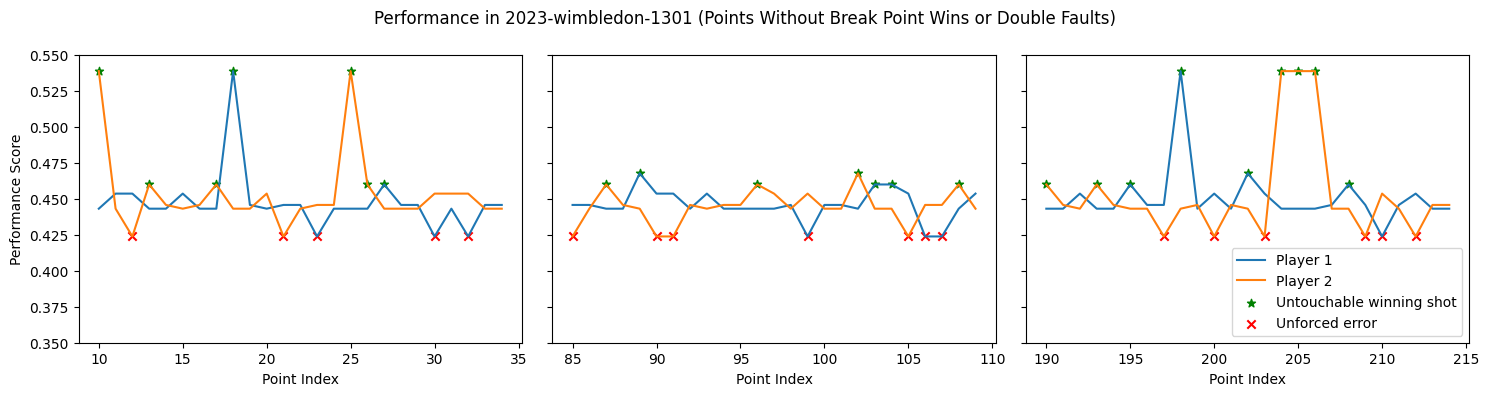

In [12]:
selected_ranges = [(10, 35), (85, 110), (190, 215)]
fig, axes = plt.subplots(1, len(selected_ranges), figsize=(5 * len(selected_ranges), 4), sharey=True)
if len(selected_ranges) == 1:
    axes = [axes]
for i, (ax, selected_range) in enumerate(zip(axes, selected_ranges)):
    plot_selected_range(ax, selected_range)
axes[0].set_ylabel("Performance Score")
axes[-1].legend(loc="lower right")
fig.suptitle(f"Performance in {match_id} (Points Without Break Point Wins or Double Faults)")
plt.tight_layout()
plt.show()